<a href="https://www.kaggle.com/code/heartzhacker/resnet50-modified-architecture?scriptVersionId=184337389" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

clahe_train1_path = "/kaggle/input/clahe-dataset/train1"
clahe_train2_path = "/kaggle/input/clahe-dataset/train2"
clahe_train3_path = "/kaggle/input/clahe-dataset/train3"
clahe_val_path = "/kaggle/input/clahe-dataset/val"

rgb_clahe_train1_path = "/kaggle/input/rgb-clahe-dataset/dataset/processed_archive/train1"
rgb_clahe_train2_path = "/kaggle/input/rgb-clahe-dataset/dataset/processed_archive/train2"
rgb_clahe_train3_path = "/kaggle/input/rgb-clahe-dataset/dataset/processed_archive/train3"
rgb_clahe_val_path = "/kaggle/input/rgb-clahe-dataset/dataset/processed_archive/val"

train1_path = "/kaggle/input/dataset/archive/train1"
train2_path = "/kaggle/input/dataset/archive/train2"
train3_path = "/kaggle/input/dataset/archive/train3"
val_path = "/kaggle/input/dataset/archive/val"


test_path = "/kaggle/input/testfile/test"

2024-06-19 07:28:17.704386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 07:28:17.704519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 07:28:17.821637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train1_generator = train_datagen.flow_from_directory(
    train1_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
clahe_train1_generator = train_datagen.flow_from_directory(
    clahe_train1_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

clahe_val_generator = val_datagen.flow_from_directory(
    clahe_val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
rgb_clahe_train1_generator = train_datagen.flow_from_directory(
    rgb_clahe_train1_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

rgb_clahe_val_generator = val_datagen.flow_from_directory(
    rgb_clahe_val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Add, Activation, BatchNormalization
from tensorflow.keras.models import Model

def conv_block(input_tensor, filters, kernel_size=3, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters):
    x = conv_block(input_tensor, filters, kernel_size=1)
    x = conv_block(x, filters, kernel_size=3)
    x = Conv2D(4 * filters, kernel_size=1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(4 * filters, kernel_size=1)(input_tensor)  # Adjust dimensions
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_model(input_shape=(224, 224, 3)):
    weights_path = '/kaggle/input/resnet50-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = ResNet50(weights=weights_path, include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:-3]:
        layer.trainable = False

    x = base_model.output
    x = conv_block(x, 1024, kernel_size=1)
    x = identity_block(x, 1024)
    x = identity_block(x, 1024)
    x = identity_block(x, 1024)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
from tensorflow.keras.optimizers import Adam

model_1 = build_model()
model_1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 115,120,418 (439.15 MB)

 Trainable params: 91,473,314 (348.94 MB)

 Non-trainable params: 23,647,104 (90.21 MB)

In [8]:
from tensorflow.keras.optimizers import Adam

model_2 = build_model()
model_2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 115,120,418 (439.15 MB)

 Trainable params: 91,473,314 (348.94 MB)

 Non-trainable params: 23,647,104 (90.21 MB)

In [9]:
from tensorflow.keras.optimizers import Adam

model_3 = build_model()
model_3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 115,120,418 (439.15 MB)

 Trainable params: 91,473,314 (348.94 MB)

 Non-trainable params: 23,647,104 (90.21 MB)

In [10]:
history_train1 = model_1.fit(
    train1_generator,
    epochs= 150, 
    validation_data=val_generator
)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718782164.317796     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 96s 614ms/step - accuracy: 0.5582 - loss: 1.7166 - val_accuracy: 0.4990 - val_loss: 0.6997
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.6440 - loss: 0.6376 - val_accuracy: 0.6020 - val_loss: 0.6684
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.7115 - loss: 0.5770 - val_accuracy: 0.5170 - val_loss: 0.7889
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.7209 - loss: 0.5612 - val_accuracy: 0.6740 - val_loss: 0.6179
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.7641 - loss: 0.4848 - val_accuracy: 0.6680 - val_loss: 0.6812
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.8007 - loss: 0.4430 - val_accuracy: 0.5530 - val_loss: 1.4297
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.8337 - loss: 0.3598 - val_accuracy: 0.5870 - val_loss: 1.3825
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.8474 - loss: 0.3338 - val_accuracy

In [11]:
history_clahe_train1 = model_2.fit(
    clahe_train1_generator,
    epochs= 150, 
    validation_data=clahe_val_generator
)

Epoch 1/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 564ms/step - accuracy: 0.5633 - loss: 1.4384 - val_accuracy: 0.5180 - val_loss: 0.6900
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.6436 - loss: 0.7133 - val_accuracy: 0.5070 - val_loss: 0.6846
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.7389 - loss: 0.5422 - val_accuracy: 0.5970 - val_loss: 0.6409
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.7851 - loss: 0.4607 - val_accuracy: 0.7430 - val_loss: 0.5224
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.8321 - loss: 0.3825 - val_accuracy: 0.7010 - val_loss: 0.5969
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.8323 - loss: 0.3772 - val_accuracy: 0.7430 - val_loss: 0.5360
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.8333 - loss: 0.3767 - val_accuracy: 0.7860 - val_loss: 0.4910
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.8818 - loss: 0.2747 - 

In [12]:
history_rgb_clahe_train1 = model_3.fit(
    rgb_clahe_train1_generator,
    epochs= 150, 
    validation_data=rgb_clahe_val_generator
)

Epoch 1/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 601ms/step - accuracy: 0.5622 - loss: 1.2220 - val_accuracy: 0.5000 - val_loss: 0.7049
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.6878 - loss: 0.5984 - val_accuracy: 0.6220 - val_loss: 0.6717
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.7403 - loss: 0.5546 - val_accuracy: 0.5950 - val_loss: 0.6373
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.8025 - loss: 0.4178 - val_accuracy: 0.7620 - val_loss: 0.5007
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.8206 - loss: 0.3965 - val_accuracy: 0.5670 - val_loss: 1.2029
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8065 - loss: 0.4336 - val_accuracy: 0.7890 - val_loss: 0.4731
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.8734 - loss: 0.2957 - val_accuracy: 0.7130 - val_loss: 0.7315
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.8652 - loss: 0.3070 - 

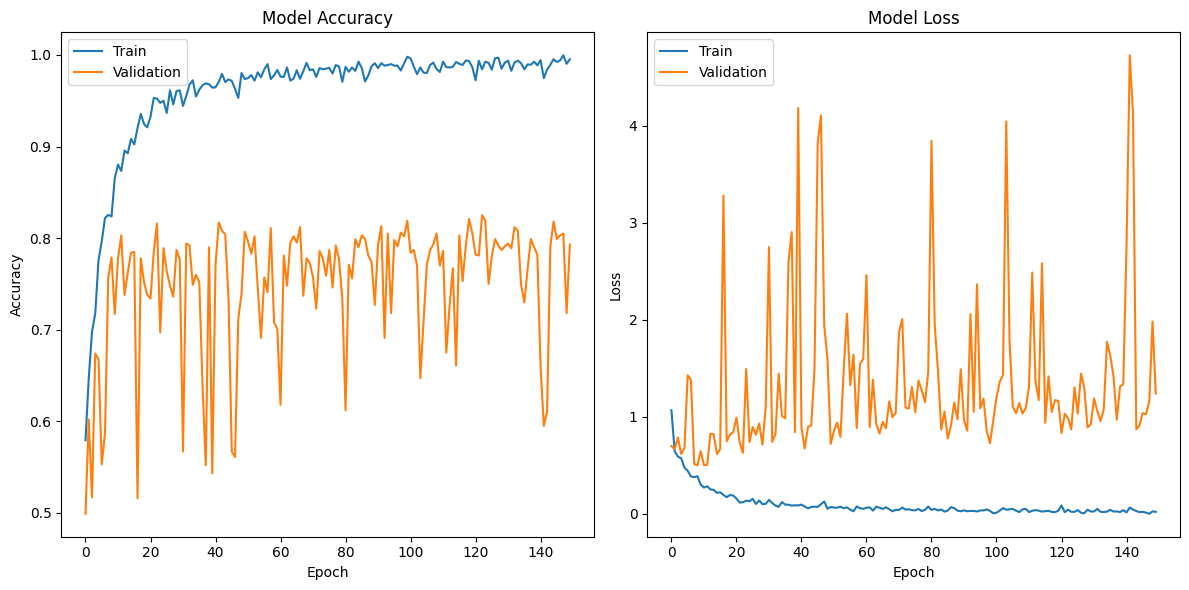

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_train1.history['accuracy'])
plt.plot(history_train1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history_train1.history['loss'])
plt.plot(history_train1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 400 images belonging to 2 classes.


In [15]:
predictions = model_1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.83      0.81      0.82       200
      polyps       0.81      0.84      0.83       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400


Confusion Matrix:
[[161  39]
 [ 32 168]]


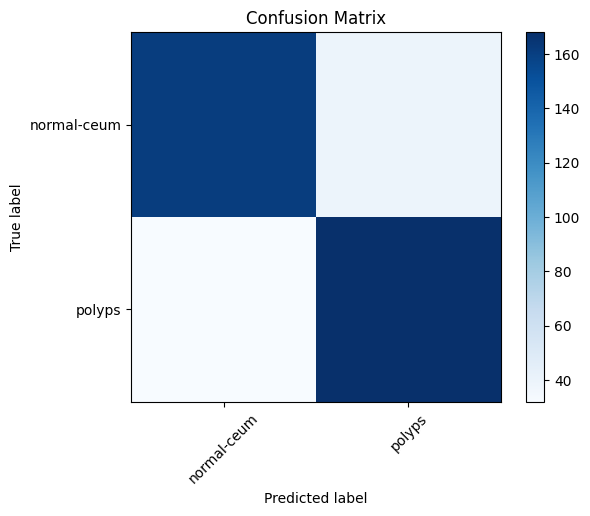

In [16]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

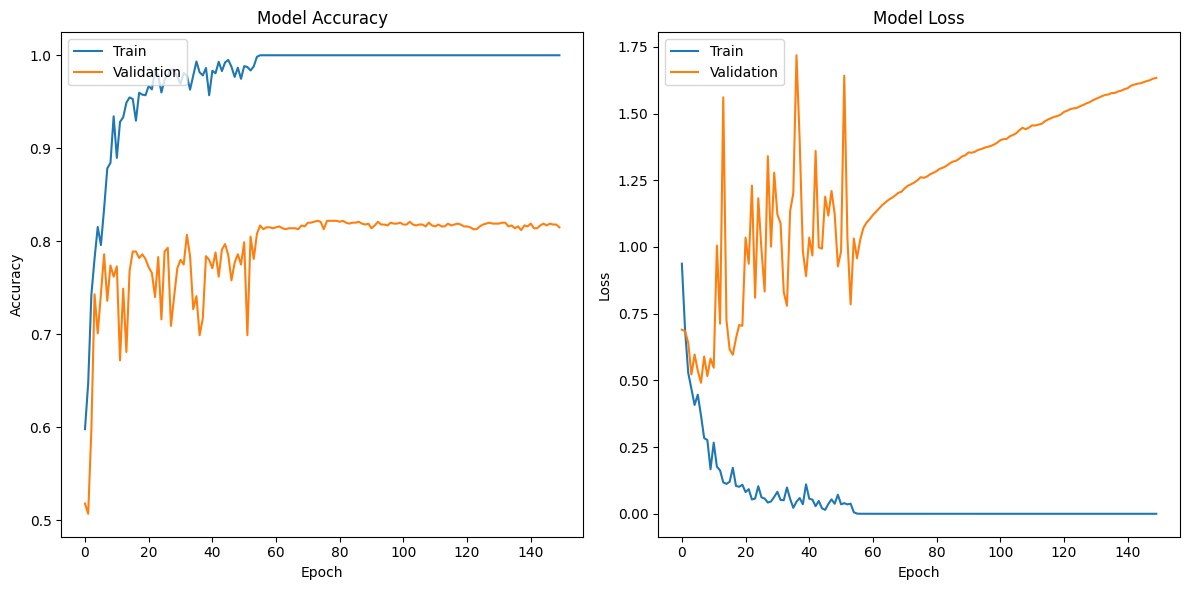

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_clahe_train1.history['accuracy'])
plt.plot(history_clahe_train1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history_clahe_train1.history['loss'])
plt.plot(history_clahe_train1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
predictions = model_2.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 526ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.87      0.60      0.71       200
      polyps       0.70      0.91      0.79       200

    accuracy                           0.76       400
   macro avg       0.78      0.76      0.75       400
weighted avg       0.78      0.76      0.75       400


Confusion Matrix:
[[121  79]
 [ 18 182]]


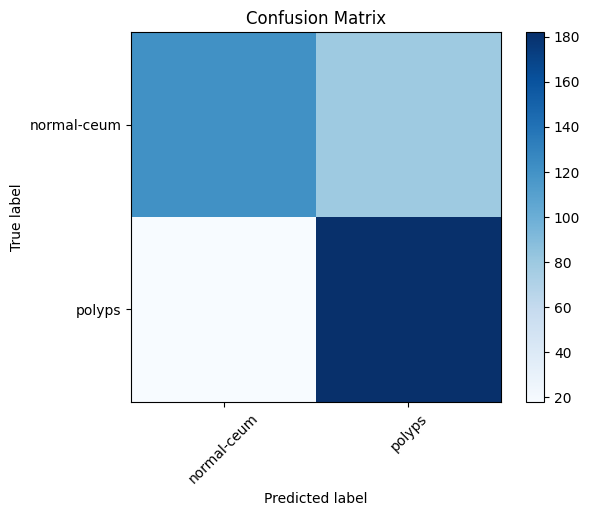

In [19]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

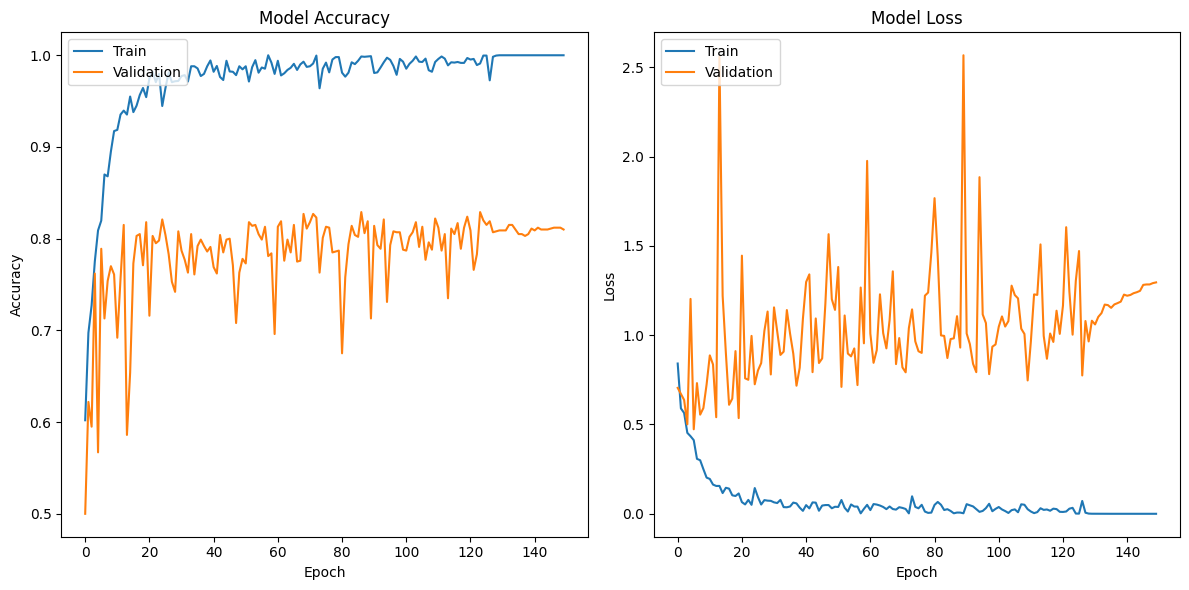

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_rgb_clahe_train1.history['accuracy'])
plt.plot(history_rgb_clahe_train1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history_rgb_clahe_train1.history['loss'])
plt.plot(history_rgb_clahe_train1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
predictions = model_3.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 527ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.82      0.81      0.81       200
      polyps       0.81      0.82      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400


Confusion Matrix:
[[161  39]
 [ 36 164]]


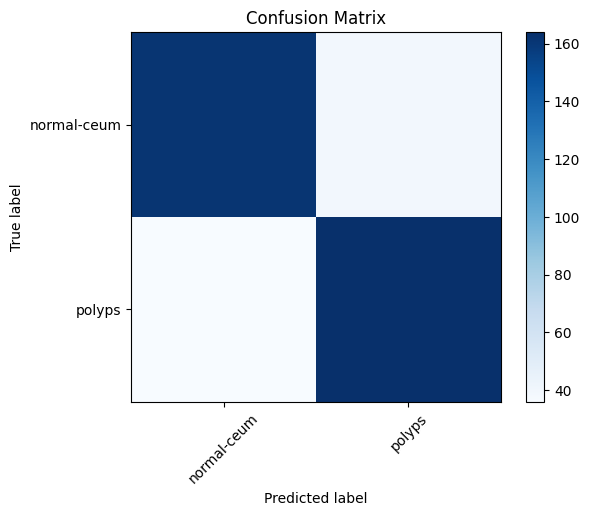

In [22]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
model_weights_path = "/kaggle/working/train1.weights.h5"
model_1.save_weights(model_weights_path)

In [24]:
model_weights_path = "/kaggle/working/clahe_train1.weights.h5"
model_2.save_weights(model_weights_path)

In [25]:
model_weights_path = "/kaggle/working/rgb_clahe_train1.weights.h5"
model_3.save_weights(model_weights_path)

In [26]:
train2_generator = train_datagen.flow_from_directory(
    train2_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

clahe_train2_generator = train_datagen.flow_from_directory(
    clahe_train2_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

rgb_clahe_train2_generator = train_datagen.flow_from_directory(
    rgb_clahe_train2_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [27]:
history_train2 = model_1.fit(
    train2_generator,
    epochs=150,  
    validation_data=val_generator
)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 322ms/step - accuracy: 0.7648 - loss: 0.7065 - val_accuracy: 0.8000 - val_loss: 0.5227
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.8334 - loss: 0.3901 - val_accuracy: 0.7460 - val_loss: 0.5581
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.8724 - loss: 0.3060 - val_accuracy: 0.8080 - val_loss: 0.4229
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.8786 - loss: 0.2819 - val_accuracy: 0.7380 - val_loss: 0.6680
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.9096 - loss: 0.2216 - val_accuracy: 0.8270 - val_loss: 0.4571
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.9110 - loss: 0.2144 - val_accuracy: 0.7470 - val_loss: 0.6919
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.9374 - loss: 0.1573 - val_accuracy: 0.7080 - val_loss: 1.0275
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9291 - loss: 0.1819 - val_accuracy

In [28]:
history_clahe_train2 = model_2.fit(
    clahe_train2_generator,
    epochs=150,  
    validation_data=clahe_val_generator
)

Epoch 1/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - accuracy: 0.6085 - loss: 1.0332 - val_accuracy: 0.4210 - val_loss: 1.0385
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.7347 - loss: 0.5481 - val_accuracy: 0.7600 - val_loss: 0.4928
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.7610 - loss: 0.5000 - val_accuracy: 0.5920 - val_loss: 0.7596
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.7886 - loss: 0.4471 - val_accuracy: 0.7350 - val_loss: 0.5362
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.8196 - loss: 0.3936 - val_accuracy: 0.5880 - val_loss: 0.9098
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.8370 - loss: 0.3666 - val_accuracy: 0.7590 - val_loss: 0.5050
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.8759 - loss: 0.3131 - val_accuracy: 0.7760 - val_loss: 0.4947
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.8779 - loss: 0.2872 - 

In [29]:
history_rgb_clahe_train2 = model_3.fit(
    rgb_clahe_train2_generator,
    epochs=150,  
    validation_data=rgb_clahe_val_generator
)

Epoch 1/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.6997 - loss: 0.8361 - val_accuracy: 0.7820 - val_loss: 0.4798
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.7941 - loss: 0.4248 - val_accuracy: 0.7750 - val_loss: 0.5364
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.8487 - loss: 0.3494 - val_accuracy: 0.8280 - val_loss: 0.3922
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.8695 - loss: 0.2959 - val_accuracy: 0.8220 - val_loss: 0.4080
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.8860 - loss: 0.2793 - val_accuracy: 0.7990 - val_loss: 0.5159
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.9220 - loss: 0.2015 - val_accuracy: 0.8490 - val_loss: 0.4081
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.9356 - loss: 0.1590 - val_accuracy: 0.8410 - val_loss: 0.4142
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.9412 - loss: 0.1410 - 

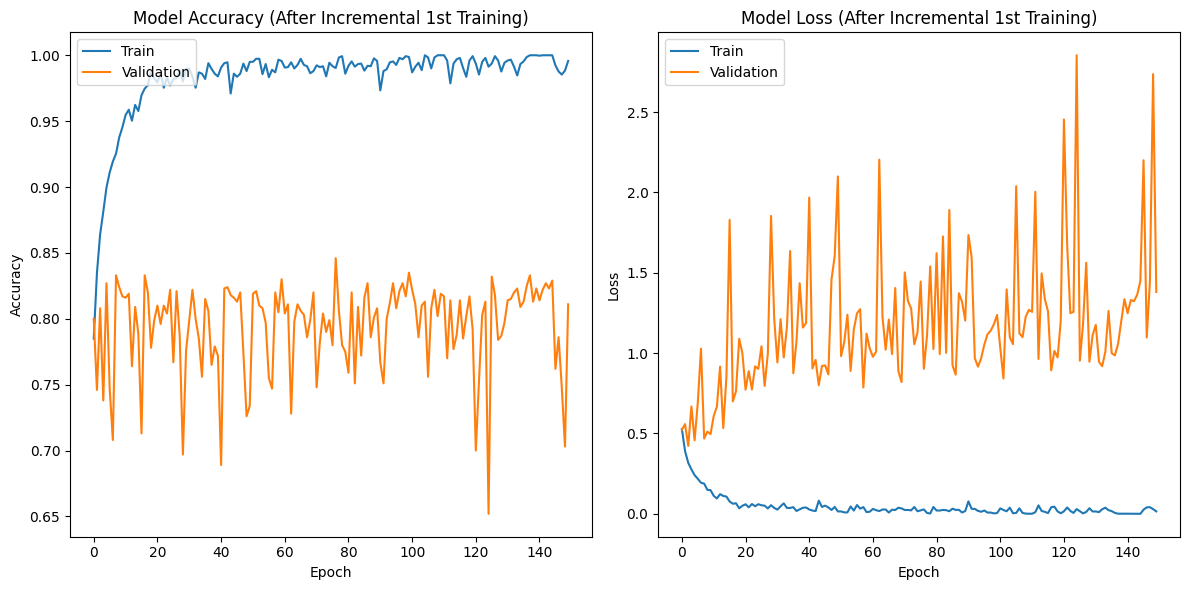

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_train2.history['accuracy'])
plt.plot(history_train2.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_train2.history['loss'])
plt.plot(history_train2.history['val_loss'])
plt.title('Model Loss (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
predictions = model_1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.79      0.94      0.86       200
      polyps       0.92      0.76      0.83       200

    accuracy                           0.84       400
   macro avg       0.86      0.84      0.84       400
weighted avg       0.86      0.84      0.84       400


Confusion Matrix:
[[187  13]
 [ 49 151]]


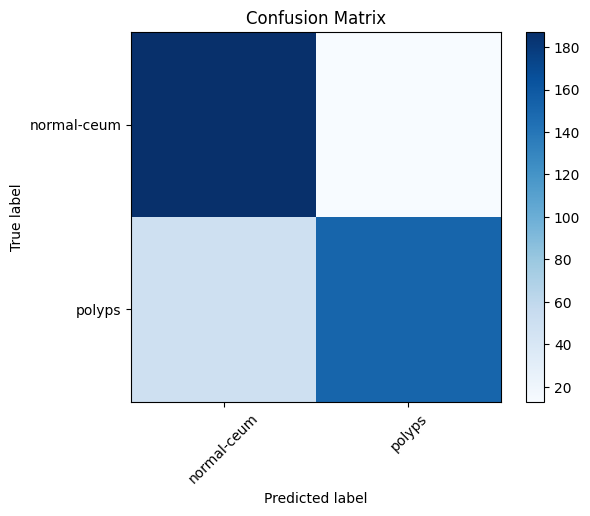

In [32]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

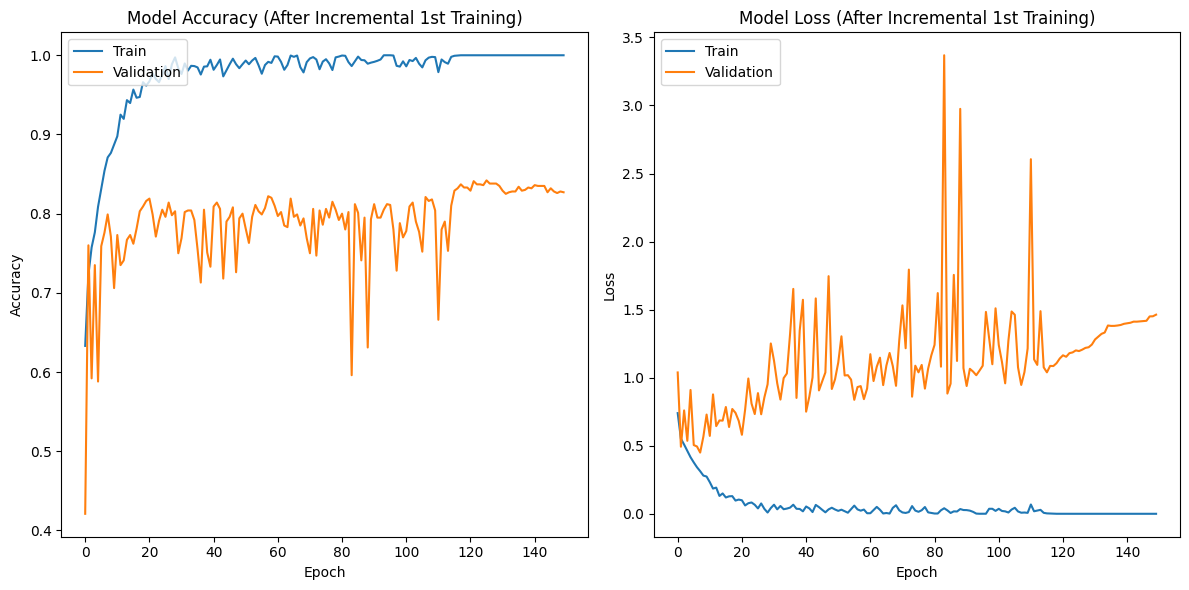

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_clahe_train2.history['accuracy'])
plt.plot(history_clahe_train2.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_clahe_train2.history['loss'])
plt.plot(history_clahe_train2.history['val_loss'])
plt.title('Model Loss (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
predictions = model_2.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.87      0.30      0.45       200
      polyps       0.58      0.95      0.72       200

    accuracy                           0.63       400
   macro avg       0.73      0.63      0.59       400
weighted avg       0.73      0.63      0.59       400


Confusion Matrix:
[[ 61 139]
 [  9 191]]


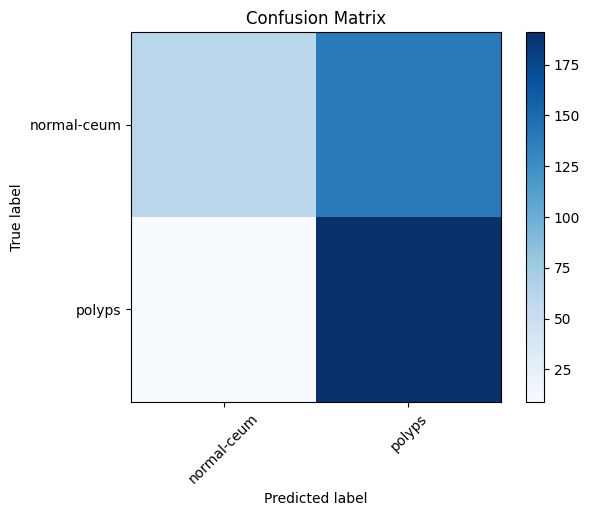

In [35]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

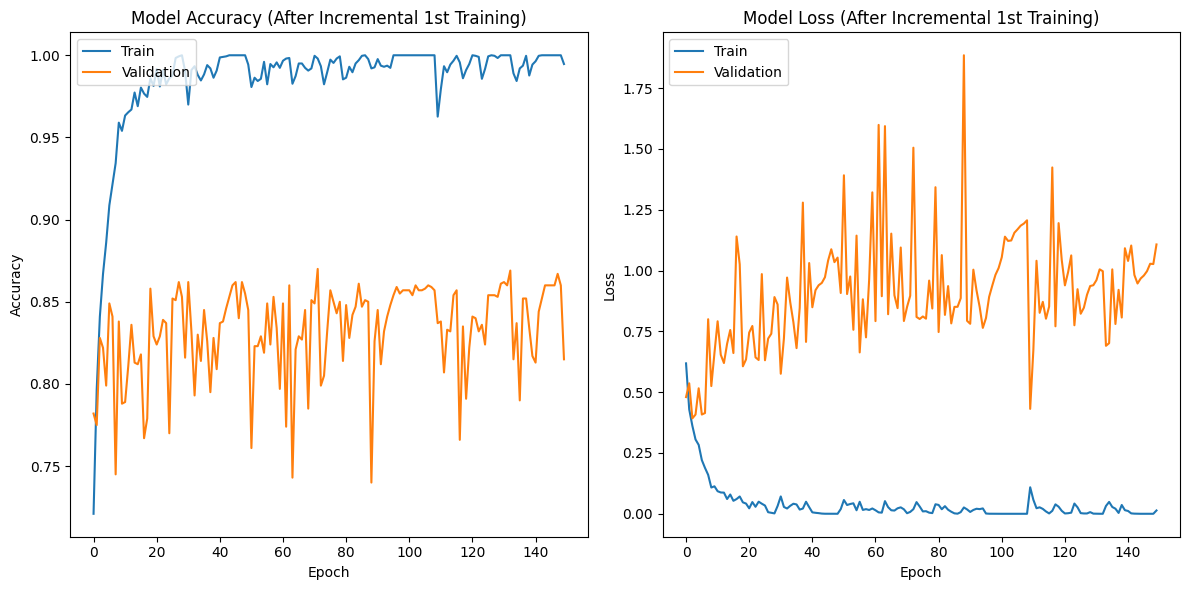

In [36]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_rgb_clahe_train2.history['accuracy'])
plt.plot(history_rgb_clahe_train2.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_rgb_clahe_train2.history['loss'])
plt.plot(history_rgb_clahe_train2.history['val_loss'])
plt.title('Model Loss (After Incremental 1st Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
predictions = model_3.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.79      0.83      0.81       200
      polyps       0.82      0.78      0.80       200

    accuracy                           0.81       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.81      0.81      0.80       400


Confusion Matrix:
[[167  33]
 [ 45 155]]


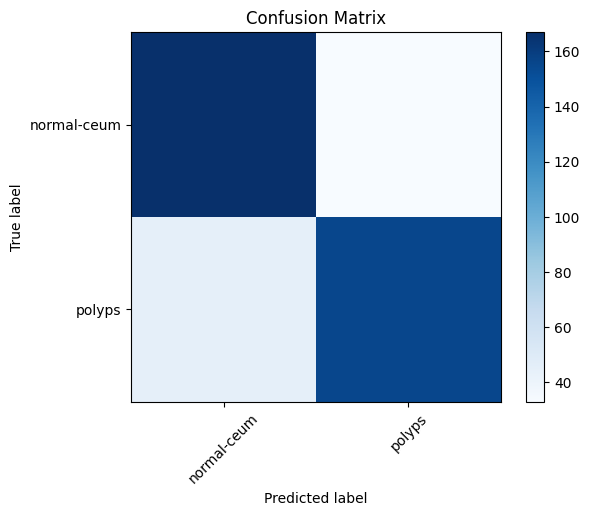

In [38]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [39]:
model_weights_path = "/kaggle/working/train2.weights.h5"
model_1.save_weights(model_weights_path)

In [40]:
model_weights_path = "/kaggle/working/clahe_train2.weights.h5"
model_2.save_weights(model_weights_path)

In [41]:
model_weights_path = "/kaggle/working/rgb_clahe_train2.weights.h5"
model_3.save_weights(model_weights_path)

In [42]:
train3_generator = train_datagen.flow_from_directory(
    train3_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

clahe_train3_generator = train_datagen.flow_from_directory(
    clahe_train3_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

rgb_clahe_train3_generator = train_datagen.flow_from_directory(
    rgb_clahe_train3_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [43]:
history_train3 = model_1.fit(
    train3_generator,
    epochs=150,  
    validation_data=val_generator
)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 335ms/step - accuracy: 0.7832 - loss: 0.6260 - val_accuracy: 0.7350 - val_loss: 0.6654
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.8518 - loss: 0.3302 - val_accuracy: 0.8370 - val_loss: 0.3831
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.8786 - loss: 0.2777 - val_accuracy: 0.8600 - val_loss: 0.3640
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9098 - loss: 0.2341 - val_accuracy: 0.7440 - val_loss: 0.7317
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.9233 - loss: 0.1834 - val_accuracy: 0.8280 - val_loss: 0.4606
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.9349 - loss: 0.1675 - val_accuracy: 0.8380 - val_loss: 0.4377
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.9472 - loss: 0.1371 - val_accuracy: 0.8660 - val_loss: 0.3816
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.9389 - loss: 0.1464 - val_accuracy

In [44]:
history_clahe_train3 = model_2.fit(
    clahe_train3_generator,
    epochs=150,  
    validation_data=clahe_val_generator
)

Epoch 1/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step - accuracy: 0.7265 - loss: 0.8426 - val_accuracy: 0.6110 - val_loss: 1.2031
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.8041 - loss: 0.4077 - val_accuracy: 0.6920 - val_loss: 0.6603
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.8494 - loss: 0.3298 - val_accuracy: 0.8140 - val_loss: 0.4239
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.8797 - loss: 0.3021 - val_accuracy: 0.6690 - val_loss: 0.7490
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.8924 - loss: 0.2607 - val_accuracy: 0.7950 - val_loss: 0.4990
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - accuracy: 0.9026 - loss: 0.2172 - val_accuracy: 0.7420 - val_loss: 0.7636
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.9306 - loss: 0.1826 - val_accuracy: 0.7760 - val_loss: 0.6377
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9384 - loss: 0.1557 - 

In [45]:
history_rgb_clahe_train3 = model_3.fit(
    rgb_clahe_train3_generator,
    epochs=150,  
    validation_data=rgb_clahe_val_generator
)

Epoch 1/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 443ms/step - accuracy: 0.7742 - loss: 0.6221 - val_accuracy: 0.6900 - val_loss: 0.6736
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.8598 - loss: 0.3291 - val_accuracy: 0.7430 - val_loss: 0.5729
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.8961 - loss: 0.2578 - val_accuracy: 0.8140 - val_loss: 0.4388
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.9156 - loss: 0.2148 - val_accuracy: 0.8280 - val_loss: 0.3794
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.9449 - loss: 0.1422 - val_accuracy: 0.8440 - val_loss: 0.4076
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9618 - loss: 0.1082 - val_accuracy: 0.7570 - val_loss: 0.9046
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.9665 - loss: 0.0996 - val_accuracy: 0.8070 - val_loss: 0.6842
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.9639 - loss: 0.0951 - 

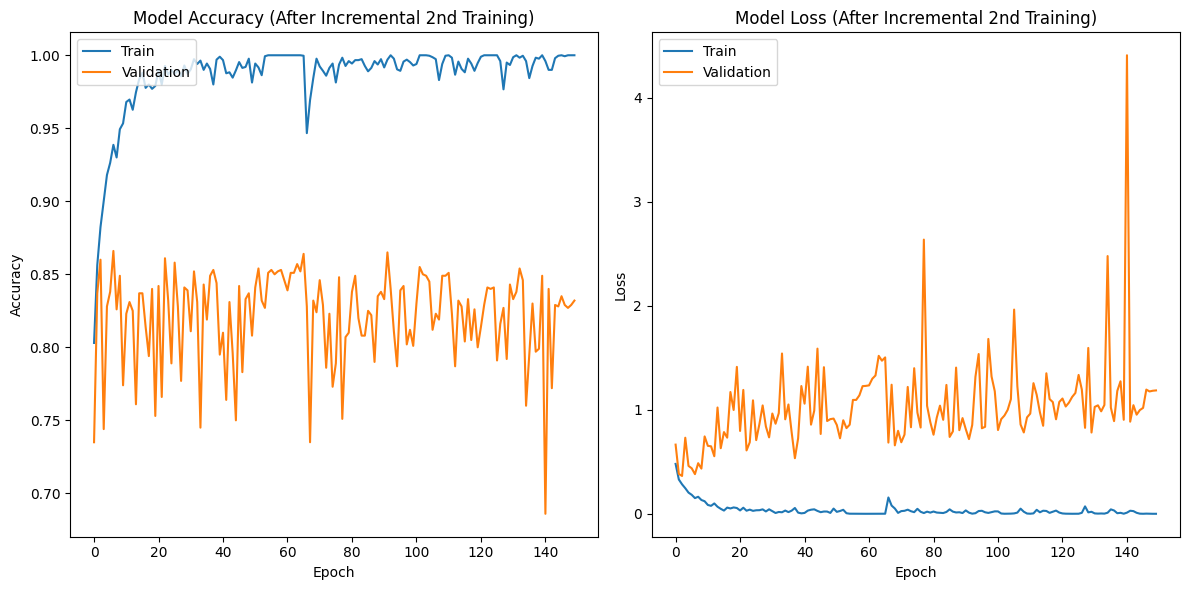

In [46]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_train3.history['accuracy'])
plt.plot(history_train3.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_train3.history['loss'])
plt.plot(history_train3.history['val_loss'])
plt.title('Model Loss (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [47]:
predictions = model_1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.81      0.85      0.83       200
      polyps       0.85      0.81      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400


Confusion Matrix:
[[171  29]
 [ 39 161]]


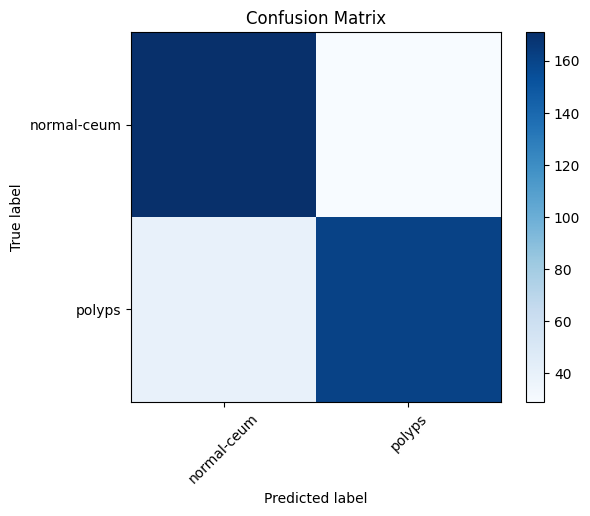

In [48]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

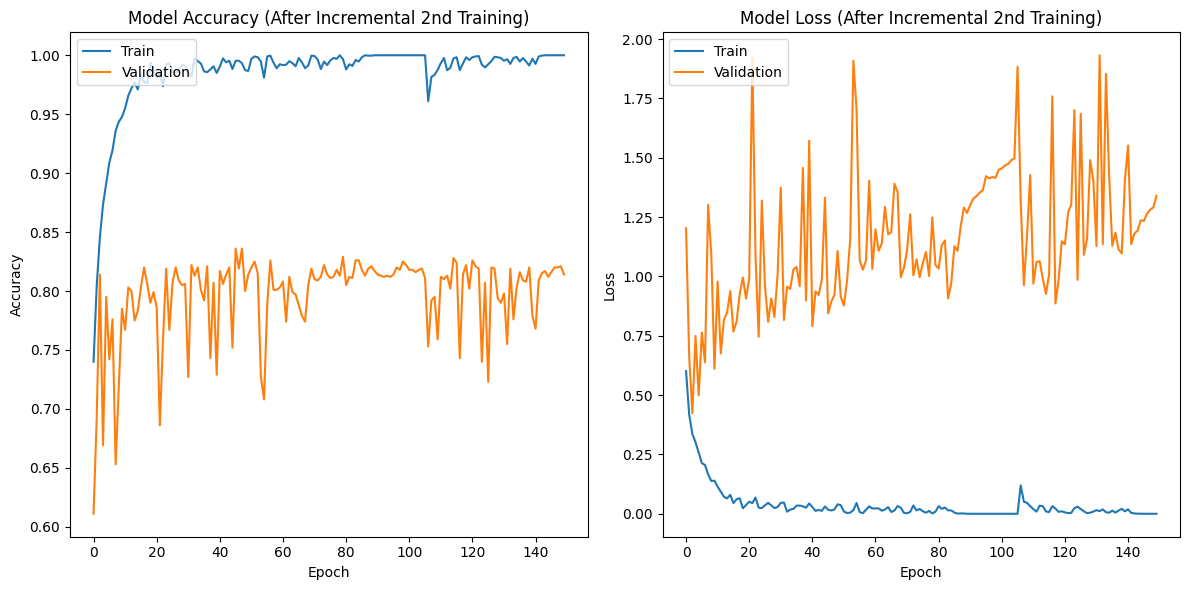

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_clahe_train3.history['accuracy'])
plt.plot(history_clahe_train3.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_clahe_train3.history['loss'])
plt.plot(history_clahe_train3.history['val_loss'])
plt.title('Model Loss (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [50]:
predictions = model_2.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.85      0.50      0.63       200
      polyps       0.65      0.92      0.76       200

    accuracy                           0.71       400
   macro avg       0.75      0.71      0.69       400
weighted avg       0.75      0.71      0.69       400


Confusion Matrix:
[[100 100]
 [ 17 183]]


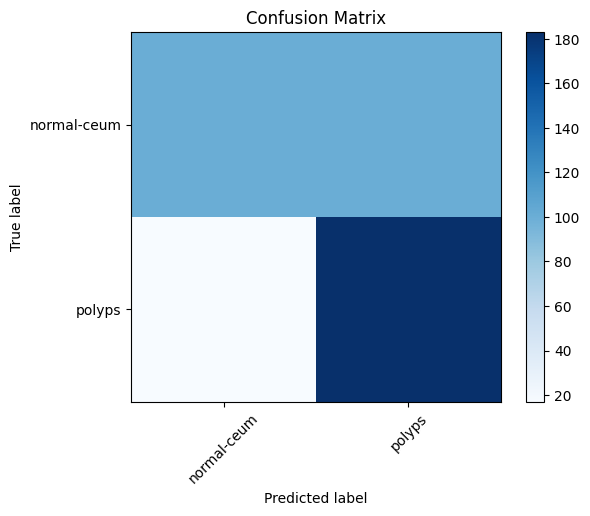

In [51]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

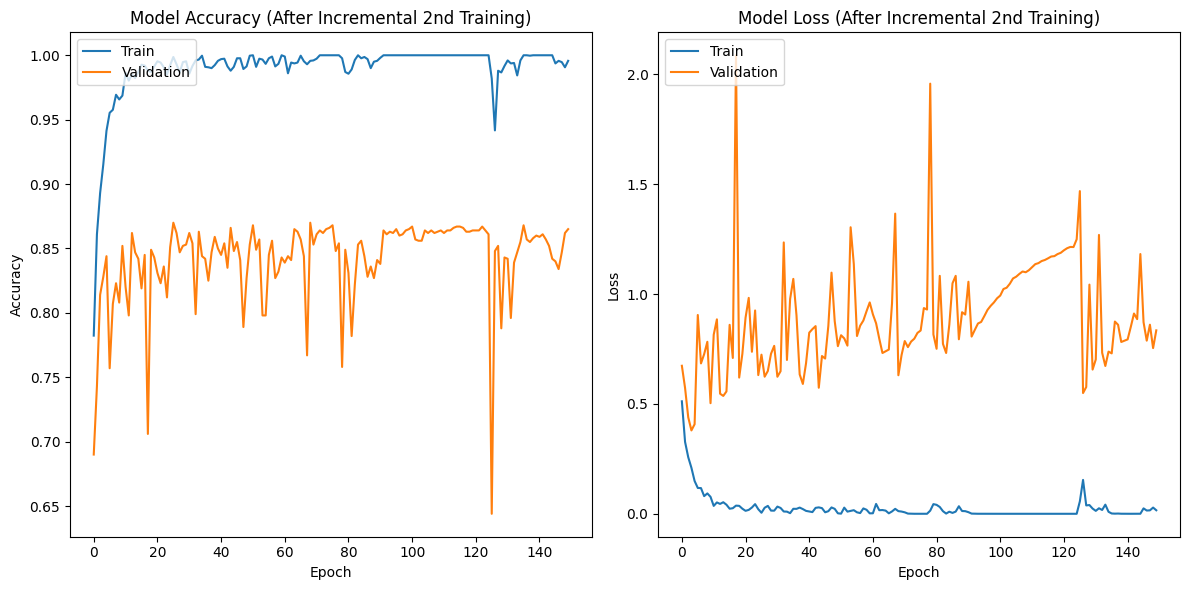

In [52]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_rgb_clahe_train3.history['accuracy'])
plt.plot(history_rgb_clahe_train3.history['val_accuracy'])
plt.title('Model Accuracy (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_rgb_clahe_train3.history['loss'])
plt.plot(history_rgb_clahe_train3.history['val_loss'])
plt.title('Model Loss (After Incremental 2nd Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [53]:
predictions = model_3.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step



Classification Report:
              precision    recall  f1-score   support

 normal-ceum       0.80      0.90      0.85       200
      polyps       0.89      0.77      0.82       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400


Confusion Matrix:
[[180  20]
 [ 46 154]]


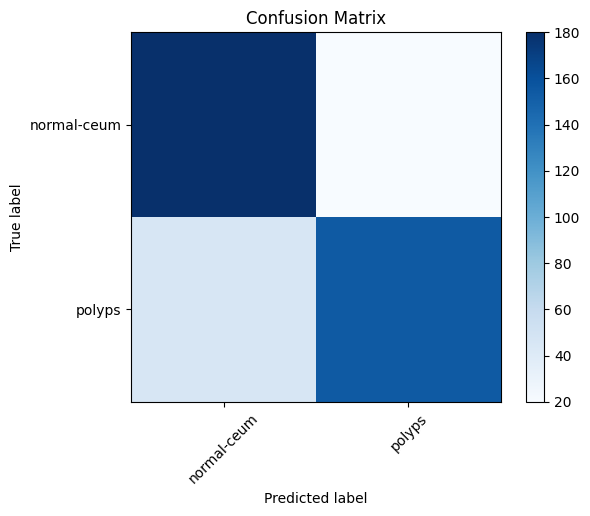

In [54]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
model_weights_path = "/kaggle/working/train3.weights.h5"
model_1.save_weights(model_weights_path)

In [56]:
model_weights_path = "/kaggle/working/clahe_train3.weights.h5"
model_2.save_weights(model_weights_path)

In [57]:
model_weights_path = "/kaggle/working/rgb_clahe_train3.weights.h5"
model_3.save_weights(model_weights_path)